In [ ]:
! python --version

### Import libs

In [1]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import word2vec
import multiprocessing
import sklearn
import spacy

import pandas as pd
import random
import numpy as np
import unicodedata
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
import logging

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

from sklearn.model_selection import StratifiedShuffleSplit
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
print(gensim.__version__)

3.8.0


### Functions to Clean Text

In [3]:
stop_words = stopwords.words('portuguese')
stop_words.pop(stop_words.index('não'))
new_stopwords = ('bom', 'dia', 'ola', 'eu')
for i in new_stopwords:
    stop_words.append(i)
    
nlp = spacy.load("pt_core_news_sm")

def anonymizer(text,stop_words):
    text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode('utf-8')
    text = re.sub(' +', ' ', str(text).lower())
    text = re.sub('((http?|ftp|smtp):\/\/)?(www.)?[a-z0-9]+\.[a-z]+(\/[a-zA-Z0-9#]+\/?)*', ' ', str(text).lower())
    text = re.sub('\S+@\S+', ' ', str(text).lower())
    text = re.sub('@\S+', ' ', str(text).lower())
    text = re.sub('\d', ' ', str(text).lower())
    text = re.sub('https:\S+', ' ', str(text).lower())
    text = re.sub('[^a-z0-9 ]+', ' ', str(text).lower())
    text = nltk.tokenize.word_tokenize(text, language='portuguese')
    return ' '.join([w for w in text if not w in stop_words])

### Analise de score do texto

### Converter as frases em um dataset pandas

In [4]:
dados = {'indices_id': ['0','1','2','3'],
         'Frase original': ['Olhando para a escala na parede, qual valor indicaria melhor a sua dor hoje?',
                           'Olhando para a escala na parede, qual valor indicaria melhor a sua dor hoje?',
                           'Olhando para a escala na parede, qual valor indicaria melhor a sua dor hoje?',
                           'Olhando para a escala na parede, qual valor indicaria melhor a sua dor hoje?'],
         'Frases comparativas': ['De acordo com a escala de dor ali na parede', 
                                'qual valor você acha que mais representa a sua dor?',
                                'De 0 a 10, qual o nível de intensidade da sua dor atualmente?',
                                'Qual a intensidade da sua dor?'],
         }

In [5]:
dataset = pd.DataFrame(dados)

In [6]:
dataset

,indices_id,Frase original,Frases comparativas
0,0,"Olhando para a escala na parede, qual valor indicaria melhor a sua dor hoje?",De acordo com a escala de dor ali na parede
1,1,"Olhando para a escala na parede, qual valor indicaria melhor a sua dor hoje?",qual valor você acha que mais representa a sua dor?
2,2,"Olhando para a escala na parede, qual valor indicaria melhor a sua dor hoje?","De 0 a 10, qual o nível de intensidade da sua dor atualmente?"
3,3,"Olhando para a escala na parede, qual valor indicaria melhor a sua dor hoje?",Qual a intensidade da sua dor?


In [7]:
dataset.shape

(4, 3)

In [8]:
dataset['frase_original_clean'] = dataset['Frase original'].apply(lambda x: anonymizer(x, stop_words))
dataset['Frases_comparativas_clean'] = dataset['Frases comparativas'].apply(lambda x: anonymizer(x, stop_words))

### Comparative original column with column clean

In [9]:
dataset[['Frase original','frase_original_clean', 'Frases comparativas','Frases_comparativas_clean']]

,Frase original,frase_original_clean,Frases comparativas,Frases_comparativas_clean
0,"Olhando para a escala na parede, qual valor indicaria melhor a sua dor hoje?",olhando escala parede valor indicaria melhor dor hoje,De acordo com a escala de dor ali na parede,acordo escala dor ali parede
1,"Olhando para a escala na parede, qual valor indicaria melhor a sua dor hoje?",olhando escala parede valor indicaria melhor dor hoje,qual valor você acha que mais representa a sua dor?,valor voce acha representa dor
2,"Olhando para a escala na parede, qual valor indicaria melhor a sua dor hoje?",olhando escala parede valor indicaria melhor dor hoje,"De 0 a 10, qual o nível de intensidade da sua dor atualmente?",nivel intensidade dor atualmente
3,"Olhando para a escala na parede, qual valor indicaria melhor a sua dor hoje?",olhando escala parede valor indicaria melhor dor hoje,Qual a intensidade da sua dor?,intensidade dor


### Creating tokens and training model Word2Vec

In [10]:
def build_corpus(data):
    corpus = []
    for sentence in data:
        word_list = sentence.split(" ")
        corpus.append(word_list)
    return corpus

def createModel_word2vec(text,size=None,min_count=None,window=None):
    model = gensim.models.word2vec.Word2Vec(text,min_count=min_count,window=window,workers=10)
    return model

In [11]:
dataset["Frases_comparativas_clean_wc"] = build_corpus(dataset['Frases_comparativas_clean'])
dataset["frase_original_clean_wc"] = build_corpus(dataset['frase_original_clean'])

In [12]:
dataset[['frase_original_clean_wc',"Frases_comparativas_clean_wc"]]

,frase_original_clean_wc,Frases_comparativas_clean_wc
0,"[olhando, escala, parede, valor, indicaria, melhor, dor, hoje]","[acordo, escala, dor, ali, parede]"
1,"[olhando, escala, parede, valor, indicaria, melhor, dor, hoje]","[valor, voce, acha, representa, dor]"
2,"[olhando, escala, parede, valor, indicaria, melhor, dor, hoje]","[nivel, intensidade, dor, atualmente]"
3,"[olhando, escala, parede, valor, indicaria, melhor, dor, hoje]","[intensidade, dor]"


### Concat columns and convert all words in vector

In [13]:
dataset["concat"] = dataset["frase_original_clean_wc"] + dataset["Frases_comparativas_clean_wc"]

In [14]:
dataset['concat']

0       [olhando, escala, parede, valor, indicaria, melhor, dor, hoje, acordo, escala, dor, ali, parede]
1     [olhando, escala, parede, valor, indicaria, melhor, dor, hoje, valor, voce, acha, representa, dor]
2    [olhando, escala, parede, valor, indicaria, melhor, dor, hoje, nivel, intensidade, dor, atualmente]
3                       [olhando, escala, parede, valor, indicaria, melhor, dor, hoje, intensidade, dor]
Name: concat, dtype: object

### Training model

In [15]:
model_wc = createModel_word2vec(dataset['concat'],min_count=1,window=10)

In [16]:
type(model_wc)

gensim.models.word2vec.Word2Vec

### Visualize Vocabulary

In [17]:
model_wc.wv.vocab

{'olhando': <gensim.models.keyedvectors.Vocab at 0x7f2114347850>,
 'escala': <gensim.models.keyedvectors.Vocab at 0x7f2114347df0>,
 'parede': <gensim.models.keyedvectors.Vocab at 0x7f21143472e0>,
 'valor': <gensim.models.keyedvectors.Vocab at 0x7f21163b23a0>,
 'indicaria': <gensim.models.keyedvectors.Vocab at 0x7f2114334550>,
 'melhor': <gensim.models.keyedvectors.Vocab at 0x7f20a8996fa0>,
 'dor': <gensim.models.keyedvectors.Vocab at 0x7f20a8a4cbe0>,
 'hoje': <gensim.models.keyedvectors.Vocab at 0x7f2114347d30>,
 'acordo': <gensim.models.keyedvectors.Vocab at 0x7f21143479a0>,
 'ali': <gensim.models.keyedvectors.Vocab at 0x7f21143471f0>,
 'voce': <gensim.models.keyedvectors.Vocab at 0x7f2114347ca0>,
 'acha': <gensim.models.keyedvectors.Vocab at 0x7f2114347520>,
 'representa': <gensim.models.keyedvectors.Vocab at 0x7f21143475e0>,
 'nivel': <gensim.models.keyedvectors.Vocab at 0x7f211436a850>,
 'intensidade': <gensim.models.keyedvectors.Vocab at 0x7f211436a430>,
 'atualmente': <gensim.mod

In [18]:
[x for x in model_wc.wv.vocab]

['olhando',
 'escala',
 'parede',
 'valor',
 'indicaria',
 'melhor',
 'dor',
 'hoje',
 'acordo',
 'ali',
 'voce',
 'acha',
 'representa',
 'nivel',
 'intensidade',
 'atualmente']

### Get similar words

In [19]:
[(item[0],round(item[1],2)) for item in model_wc.most_similar('dor')]

<ipython-input-19-caf29175ad26>:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  [(item[0],round(item[1],2)) for item in model_wc.most_similar('dor')]


[('olhando', 0.21),
 ('hoje', 0.16),
 ('indicaria', 0.09),
 ('atualmente', 0.05),
 ('representa', 0.05),
 ('acha', 0.01),
 ('nivel', 0.0),
 ('escala', -0.0),
 ('voce', -0.01),
 ('valor', -0.02)]

In [20]:
keys = [x for x in model_wc.wv.vocab]
embedding_clusters = []
word_clusters = []
for word in keys:
    print(word)
    embeddings = []
    words = []
    for similar_word, _ in model_wc.most_similar(word, topn=30):
        words.append(similar_word)
        embeddings.append(model_wc[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)
    
    model_wc.most_similar

olhando
escala
parede
valor
indicaria
melhor
dor
hoje
acordo
ali
voce
acha
representa
nivel
intensidade
atualmente


<ipython-input-20-d76d8bbdbf23>:8: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  for similar_word, _ in model_wc.most_similar(word, topn=30):
<ipython-input-20-d76d8bbdbf23>:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embeddings.append(model_wc[similar_word])


### Word Embedding

In [21]:
from sklearn.manifold import TSNE
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=10, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f20a77bf8b0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


### Plot with similar words

In [22]:
import matplotlib.cm as cm

def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

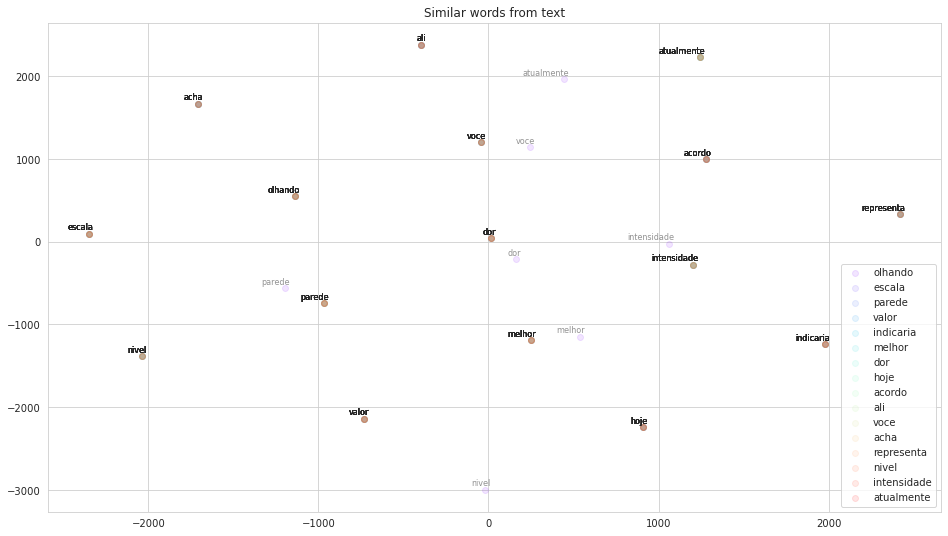

In [23]:
tsne_plot_similar_words('Similar words from text', keys, embeddings_en_2d, word_clusters, 0.1,
                        'similar_words.png')

In [24]:
w2v_vocab = set(model_wc.wv.vocab)
print("Loaded {} words in vocabulary".format(len(w2v_vocab)))

Loaded 16 words in vocabulary


### Make a similarity matrix for words and visualise

In [25]:
words = [x for x in model_wc.wv.vocab]
similarities = np.zeros((len(words), len(words)), dtype=np.float_)
for idx1, word1 in enumerate(words):
    for idx2, word2 in enumerate(words):
        # note KeyError is possible if word doesn't exist
        sim = model_wc.similarity(word1, word2)
        similarities[idx1, idx2] = sim
        
df = pd.DataFrame.from_records(similarities, columns=words)
df.index = words

<ipython-input-25-c1eab9ff789f>:6: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  sim = model_wc.similarity(word1, word2)


In [26]:
df

,olhando,escala,parede,valor,indicaria,melhor,dor,hoje,acordo,ali,voce,acha,representa,nivel,intensidade,atualmente
olhando,1.000000,0.030633,0.084046,-0.053753,-0.158713,0.178493,0.205898,0.017808,-0.123317,0.002021,-0.005897,0.118273,-0.125348,0.171982,0.021871,0.201989
escala,0.030633,1.000000,0.067365,0.004221,-0.025403,0.230036,-0.001540,-0.041029,-0.052647,-0.014215,0.031527,0.050856,-0.268063,0.138677,-0.215501,-0.032406
parede,0.084046,0.067365,1.000000,0.116811,-0.116049,-0.142603,-0.063237,-0.121337,0.015238,-0.015259,-0.005122,0.111942,-0.281350,0.145914,0.058957,0.258905
valor,-0.053753,0.004221,0.116811,1.000000,0.091874,0.027703,-0.016172,0.064450,-0.074655,-0.128907,0.089191,-0.191614,-0.215627,0.111916,0.039911,-0.038623
indicaria,-0.158713,-0.025403,-0.116049,0.091874,1.000000,-0.118503,0.090816,0.087679,0.052418,0.045216,0.051139,-0.086351,-0.052281,0.178763,0.000606,0.050478
melhor,0.178493,0.230036,-0.142603,0.027703,-0.118503,1.000000,-0.160897,-0.045741,-0.141568,0.083696,0.083114,-0.008586,-0.061149,0.072082,-0.150538,-0.069775
dor,0.205898,-0.001540,-0.063237,-0.016172,0.090816,-0.160897,1.000000,0.156212,-0.076767,-0.350622,-0.012320,0.006391,0.046929,0.004741,-0.044929,0.052876
hoje,0.017808,-0.041029,-0.121337,0.064450,0.087679,-0.045741,0.156212,1.000000,0.089469,-0.186104,0.167324,0.014259,-0.017198,0.206437,0.007752,-0.033757
acordo,-0.123317,-0.052647,0.015238,-0.074655,0.052418,-0.141568,-0.076767,0.089469,1.000000,-0.040117,-0.090044,-0.105884,0.111882,-0.079892,-0.015346,0.119539
ali,0.002021,-0.014215,-0.015259,-0.128907,0.045216,0.083696,-0.350622,-0.186104,-0.040117,1.000000,0.032134,-0.001436,0.037610,-0.017734,-0.049106,0.044918


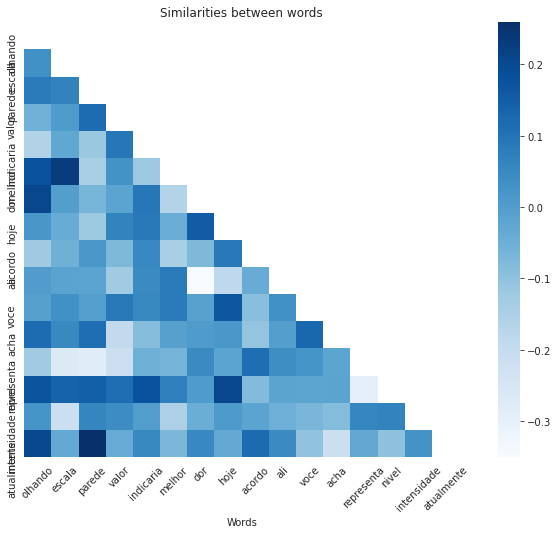

In [27]:
f, ax=plt.subplots(1, 1, figsize=(14,8))
cmap = plt.cm.Blues
mask = np.zeros_like(df)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df, cmap=cmap, mask=mask, square=True, ax=ax)
_=plt.yticks(rotation=90)
plt.xlabel('Words')
_=plt.xticks(rotation=45)
_=plt.title("Similarities between words")

### Score a target sentence to source sentences

In [28]:
#target_sentence = "You'd love to drink a cool refreshing Coke"
target_sentence = ["Olhando para a escala na parede, qual valor indicaria melhor a sua dor hoje?",
                  "De acordo com a escala de dor ali na parede",
                  'qual valor você acha que mais representa a sua dor?',
                                'De 0 a 10, qual o nível de intensidade da sua dor atualmente?',
                                'Qual a intensidade da sua dor?']

In [29]:
# use n_similarity to compute a cosine similarity (should be reasonably robust)

for i in target_sentence:
    sentences = [x for x in model_wc.wv.vocab]
    sentences_similarity = np.zeros(len(sentences))

    target_sentence_words = [w for w in i.split() if w in w2v_vocab]
    for idx, sentence in enumerate(sentences):
        sentence_words = [w for w in sentence.split() if w in w2v_vocab]
        sim = model_wc.n_similarity(target_sentence_words, sentence_words)
        sentences_similarity[idx] = sim

    result = list(zip(sentences_similarity, sentences))
    result.sort(key=lambda item:item[0], reverse=True)
    print("Target:", target_sentence)
    print(result)

Target: ['Olhando para a escala na parede, qual valor indicaria melhor a sua dor hoje?', 'De acordo com a escala de dor ali na parede', 'qual valor você acha que mais representa a sua dor?', 'De 0 a 10, qual o nível de intensidade da sua dor atualmente?', 'Qual a intensidade da sua dor?']
[(0.5264478325843811, 'escala'), (0.4757067859172821, 'valor'), (0.45198529958724976, 'indicaria'), (0.42838427424430847, 'dor'), (0.4060628414154053, 'melhor'), (0.21860340237617493, 'nivel'), (0.10336467623710632, 'voce'), (0.10083707422018051, 'hoje'), (0.09225820749998093, 'olhando'), (-0.013779323548078537, 'atualmente'), (-0.05921066924929619, 'parede'), (-0.09790153056383133, 'acha'), (-0.1275934875011444, 'acordo'), (-0.16127707064151764, 'intensidade'), (-0.16993826627731323, 'ali'), (-0.23705007135868073, 'representa')]
Target: ['Olhando para a escala na parede, qual valor indicaria melhor a sua dor hoje?', 'De acordo com a escala de dor ali na parede', 'qual valor você acha que mais represe

<ipython-input-29-589428ef2963>:10: DeprecationWarning: Call to deprecated `n_similarity` (Method will be removed in 4.0.0, use self.wv.n_similarity() instead).
  sim = model_wc.n_similarity(target_sentence_words, sentence_words)


### Test some word relationships

In [30]:
model_wc.most_similar(positive=["acordo", "melhor"], negative=['dor', 'intensidade'])

<ipython-input-30-60883f20d73e>:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  model_wc.most_similar(positive=["acordo", "melhor"], negative=['dor', 'intensidade'])


[('ali', 0.210524320602417),
 ('escala', 0.18731258809566498),
 ('voce', 0.034606292843818665),
 ('atualmente', -0.014441309496760368),
 ('acha', -0.018062174320220947),
 ('representa', -0.025636760517954826),
 ('valor', -0.03357068449258804),
 ('nivel', -0.03661074861884117),
 ('hoje', -0.057099681347608566),
 ('parede', -0.0584522970020771)]

### Project a set of words (via their 30 dimensional vector) using T-SNE

<ipython-input-31-da48ab1e3c05>:7: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  for word, _ in model_wc.most_similar(woi):
<ipython-input-31-da48ab1e3c05>:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vectors.append(model_wc[word])
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f20a242be50>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
 

Text(0.5, 1.0, "Word similarity (T-SNE) using vectors from 16 words\nColoured by similarity to 'dor'")

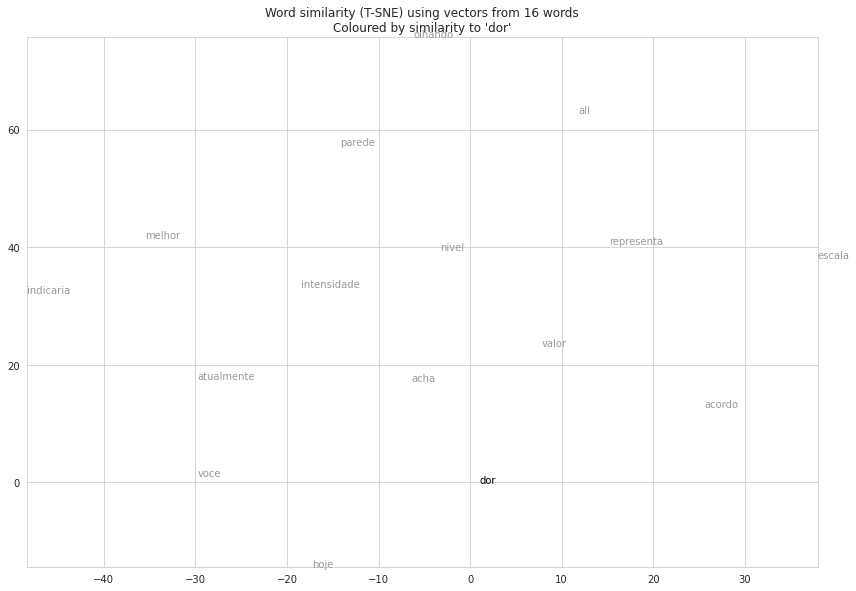

In [31]:
from sklearn.manifold import TSNE

raw_words_of_interest = [x for x in model_wc.wv.vocab]

words_of_interest = []
for woi in raw_words_of_interest:
    for word, _ in model_wc.most_similar(woi):
        words_of_interest.append(word)

words_of_interest = list(set(words_of_interest))

vectors = []
for word in set(words_of_interest):
    vectors.append(model_wc[word])
    
vectors = np.vstack(vectors) # turn vectors into a 2D array <words x 300dim>

model = TSNE(n_components=2, perplexity=10, random_state=0)
X_tsne = model.fit_transform(vectors)
df_after_tsne = pd.DataFrame.from_records(X_tsne, columns=['x', 'y'])
df_after_tsne['labels'] = words_of_interest

# calculate similarity from a target word to all words, to use as our colour
target_word = "dor"
similarities = []
for woi in words_of_interest:
    similarity = min(max(0, model_wc.similarity(target_word, woi)), 1.0)
    similarities.append(similarity)

# plot the T-SNE layout for words, darker words means more similar to our target
plt.figure(figsize=(12,8))
plt.xlim((min(X_tsne[:,0]), max(X_tsne[:,0])))
plt.ylim((min(X_tsne[:,1]), max(X_tsne[:,1])))
for idx in range(X_tsne.shape[0]):
    x, y = X_tsne[idx]
    label = words_of_interest[idx]
    color=str(min(0.6, 1.0-similarities[idx])) # convert to string "0.0".."1.0" as greyscale for mpl
    plt.annotate(s=label, xy=(x, y), color=color)
    #plt.annotate(s=label, xy=(x, y), weight=int(similarities[idx]*1000)) # use weight
plt.tight_layout()
plt.title("Word similarity (T-SNE) using vectors from {} words\nColoured by similarity to '{}'".format(len(words_of_interest), target_word))